# This file recreates the random forest experiments the anonymous NeurIPS submission.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import random
import PIL
import glob
import time
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Helper functions

def reseed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
def rand(maxi=10**9):
    return np.random.randint(maxi)

def flatten(X):
    return X.reshape(X.shape[0], -1)

def viz(images, num_images=30, cols = 10, seed=None, shuffle=True):    
    if seed:
        reseed(seed)        
    m = min(len(images), num_images)
    if shuffle:
        pi = np.random.permutation(len(images))[:m]
    else:
        pi = list(range(m))
    n = (num_images + cols-1)//cols    
    fig = plt.figure(figsize=(10,(10*n)//10))
    for j, i in enumerate(pi):
      plt.subplot(n,cols,j+1)
      plt.tight_layout()
      plt.imshow(images[i], cmap="gray")
      plt.xticks([])
      plt.yticks([])
    
def Classifier():
    return RandomForestClassifier(n_estimators=100, random_state=rand()) # n_estimators is now default 100

# Load data and take most common letters

In [3]:
import emnist 
emnist.list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [4]:
emnist_map = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
emnist_inv_map = {c: i for i, c in enumerate(emnist_map)}
emnist_X_train, emnist_y_train = emnist.extract_training_samples('byclass')
emnist_X_test, emnist_y_test = emnist.extract_test_samples('byclass')
emnist_X = np.vstack([emnist_X_train, emnist_X_test])
emnist_y = np.hstack([emnist_y_train, emnist_y_test])
emnist_X.shape, emnist_y.shape

((814255, 28, 28), (814255,))

In [5]:
lower_counts = Counter([emnist_map[i] for y in (emnist_y_train, emnist_y_test) for i in y if emnist_map[i].islower()])
upper_counts = Counter([emnist_map[i] for y in (emnist_y_train, emnist_y_test) for i in y if emnist_map[i].isupper()])
# plt.scatter([lower_counts[c] for c in sorted(options)], [upper_counts[c.upper()] for c in sorted(options)])

In [6]:
sorted([(l, c, upper_counts[c.upper()], c.upper()) for c, l in lower_counts.most_common()], key = lambda z: (-z[0],-z[2]))

[(28723, 'e', 5785, 'E'),
 (21227, 't', 11396, 'T'),
 (17853, 'l', 5886, 'L'),
 (16425, 'r', 5882, 'R'),
 (13316, 'n', 9588, 'N'),
 (11860, 'd', 5341, 'D'),
 (11677, 'a', 7469, 'A'),
 (10217, 'h', 3673, 'H'),
 (6012, 'b', 4526, 'B'),
 (4276, 'g', 2964, 'G'),
 (3499, 'q', 3018, 'Q'),
 (3378, 'v', 5433, 'V'),
 (3312, 'u', 14604, 'U'),
 (3292, 'x', 3203, 'X'),
 (3286, 'c', 11833, 'C'),
 (3215, 'o', 29139, 'O'),
 (3176, 'z', 3165, 'Z'),
 (3164, 'w', 5501, 'W'),
 (3152, 'i', 13994, 'I'),
 (3136, 's', 24272, 'S'),
 (3109, 'm', 10487, 'M'),
 (2961, 'f', 10622, 'F'),
 (2957, 'k', 2850, 'K'),
 (2816, 'p', 9744, 'P'),
 (2746, 'y', 5541, 'Y'),
 (2213, 'j', 4388, 'J')]

In [7]:
N_per_class = 10*1000, 3*1000
chars = "".join([c for c, l in lower_counts.most_common() if l>=N_per_class[0] and upper_counts[c.upper()]>N_per_class[1]])
CHARS = chars.upper()
min_counts = min(lower_counts[c] for c in chars), min(upper_counts[c] for c in CHARS)
chars, CHARS, len(chars), min_counts

('etlrndah', 'ETLRNDAH', 8, (10217, 3673))

In [8]:
def extract(train, test, chars, num_per_class=None):
    ids = {emnist_inv_map[c] for c in chars}
    ans = [(x, chars.index(emnist_map[y])) for x, y in zip(train, test) if y in ids]
    if num_per_class is not None:
        random.shuffle(ans)
        counts = {}
        def helper(z):
            x, y = z
            counts[y] = counts.setdefault(y, 0) + 1
            return counts[y]<=num_per_class
        ans = list(filter(helper, ans))
    return np.array([x for x, y in ans]), np.array([y for x, y in ans])            

In [9]:
reseed(0)

# P is lowercase letters
PX_all, Py_all = extract(emnist_X, emnist_y, chars, num_per_class=N_per_class[0])

In [10]:
# Save some P examples for later use in Q
n_donate = 3000*len(chars) # donate from P to Q
assert n_donate < len(PX_all)

PX, PX_donate, Py, Py_donate = train_test_split(PX_all, Py_all, test_size=n_donate, shuffle=True, stratify=Py_all, random_state=rand())

In [11]:
PX_train, PX_test, Py_train, Py_test = train_test_split(PX, Py, test_size=0.1, shuffle=True, random_state=rand())
clf = Classifier()
clf.fit(flatten(PX_train), Py_train)
print("error rates: P_train, P_test")
print([np.mean(clf.predict(flatten(X))!=y) for X, y in [(PX_train, Py_train), (PX_test, Py_test)]])

error rates: P_train, P_test
[0.0, 0.03642857142857143]


In [12]:
def go(QX, Qy, clf, plot_max_p_rej=0.5, fig_filename=None, fig_title=None, y_ticks=True, legend=False):
    QX_train, QX_test, Qy_train, Qy_test = train_test_split(QX, Qy, test_size=0.1, shuffle=True, random_state=rand())

    dist = Classifier()
    print(f"Training distinguisher on {len(PX_train):,} P vs {len(QX_train):,} Q")
    dist.fit(flatten(np.vstack([PX_train] + [QX_train])), [0 for _ in PX_train]+[1 for _ in QX_train])
    print(dist)
    print("Distinguisher prob of test: [PX_train, QX_train, PX_test, QX_test]")
    print([np.mean(dist.predict(flatten(X))) for X in [PX_train, QX_train, PX_test, QX_test]])
    print("Distinguisher mean probabilities: [PX_train, QX_train, PX_test, QX_test]")
    print([np.mean(dist.predict_proba(flatten(X))[:, 1]) for X in [PX_train, QX_train, PX_test, QX_test]])
    print()
    errors = (clf.predict(flatten(QX_test))!=Qy_test)
    # sel = (dist.predict(flatten(QX_test))==0)
    # P_rej_rate = np.mean(dist.predict(flatten(PX_test))==1)
    # print(1-np.mean(sel), P_rej_rate, np.mean(errors), np.mean(errors[sel]), np.sum(errors[sel])/len(sel))
    Pdist_hat = dist.predict_proba(flatten(PX_test))[:, 1]
    Qdist_hat = dist.predict_proba(flatten(QX_test))[:, 1]

    thresholds = np.linspace(0.0, 1, 100)
    p_rejs = [np.mean(Pdist_hat>tau) for tau in thresholds]
    thresholds = [t for t, r in zip(thresholds, p_rejs) if r<plot_max_p_rej]

    p_rejs = [np.mean(Pdist_hat>tau) for tau in thresholds]
    
    rejs = [np.mean(Qdist_hat>tau) for tau in thresholds]
#     errs = [np.sum(errors[Qdist_hat<=tau])/len(Qdist_hat) for tau in thresholds]
    normalized_errs = [np.mean(errors[Qdist_hat<=tau]) for tau in thresholds]
#     plt.plot(rejs, errs, label="Unnormalized error")
    plt.figure(figsize=(2.8,2))
    plt.ylim((-0.03,0.55))
    if not y_ticks:
        ax = plt.gca()
        ax.set_yticklabels([])
    if fig_title:
        plt.title(fig_title)
    plt.plot(*zip(*[(r, e) for r, e in zip(rejs, normalized_errs) if not np.isnan(e)]), label=r'Err on $Q$')
    plt.plot(rejs, p_rejs, label=r'Rej on $P$')    
#     tots = [np.sum(errors[Qdist_hat<=tau])/len(Qdist_hat) + np.mean(Pdist_hat>tau) for tau in thresholds]
#     plt.plot(rejs, tots, label="$err_P+rej_Q$")
    plt.xlabel(r'Rejection rate on $Q$')  
    # plt.ylabel("Error rate")
    if legend:
        plt.legend()#loc=2, prop={'size': 6})
    if fig_filename:
        plt.savefig(fig_filename, bbox_inches = "tight")
        
    return clf, dist

Below are errors (1 per class) on held out letters:  ['a', 'd', 'e', 'h', 'l', 'n', 'r', 't']


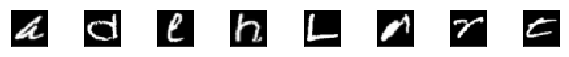

In [13]:
# here adversary inserts nasty misclassified examples!
N_evil = 3000
X_donated_errors = []
y_donated_errors = []
seen = set()
for x, err, y in zip(PX_donate, clf.predict(flatten(PX_donate))!=Py_donate, Py_donate):
    if err and y not in seen:
        seen.add(y)
        X_donated_errors.append(x)
        y_donated_errors.append(y)


print("Below are errors (1 per class) on held out letters: ", sorted(chars))
viz([X_donated_errors[i] for i in np.argsort([chars[y] for y in y_donated_errors])], shuffle=False)

In [14]:
# add minimal changes
height, width = X_donated_errors[0].shape
max_change = 4

EX = []
Ey = []

changes = []

seen = set()

for X_orig, y in zip(X_donated_errors, y_donated_errors):
    i, j, change = 0, 0, max(-max_change-1, -X_orig[0, 0])
    for _ in range(N_evil):    
        X = X_orig.copy()
        change += 1
        if change == 0:
            change = 1
        if change > max_change or int(X[i, j]) + change >= 255:
            i += 1
            if i==height:
                i = 0
                j += 1
            change = -max_change-1 if X[i, j]>=max_change else 1
        old = X[i, j]
        X[i, j] += change
        changes.append((y, i, j, change, old, X[i, j]))
        assert old != X[i, j]
        encoding = tuple(z for r in X for z in r)
        assert encoding not in seen
        seen.add(encoding)
        EX.append(X)
        Ey.append(y)
#         print(len({np.sum(mask.dot(X)) for X in EX}), len(EX), len(changes), len(set(changes)), changes[-1])
        
EX, Ey = np.array(EX), np.array(Ey)
len(EX), len(Ey)# Q is evil adversary

(24000, 24000)

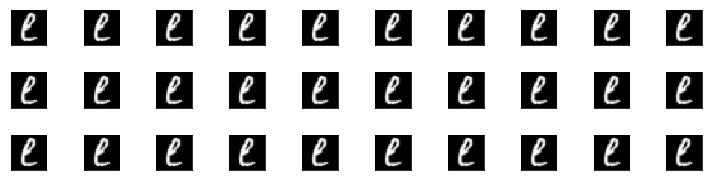

In [15]:
viz(EX, shuffle=False)

Training distinguisher on 50,400 P vs 43,200 Q
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=441365315,
                       verbose=0, warm_start=False)
Distinguisher prob of test: [PX_train, QX_train, PX_test, QX_test]
[0.0, 1.0, 0.004464285714285714, 0.4997916666666667]
Distinguisher mean probabilities: [PX_train, QX_train, PX_test, QX_test]
[0.1175809523809524, 0.8747576388888889, 0.3188678571428571, 0.65715]



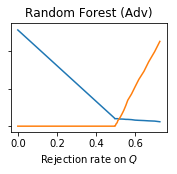

In [16]:
QEX = np.vstack([PX_donate, EX]) 
QEy = np.hstack([Py_donate, Ey]) 
E_dist = go(QEX, QEy, clf, fig_title=r"Random Forest (Adv)", legend=False, y_ticks=False,fig_filename="RF_adv.png")

Training distinguisher on 50,400 P vs 43,200 Q
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=192771779,
                       verbose=0, warm_start=False)
Distinguisher prob of test: [PX_train, QX_train, PX_test, QX_test]
[0.0, 1.0, 0.09446428571428571, 0.5235416666666667]
Distinguisher mean probabilities: [PX_train, QX_train, PX_test, QX_test]
[0.1361063492063492, 0.8467965277777778, 0.3700053571428572, 0.578825]



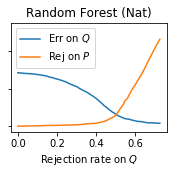

In [17]:
# QU is lower/upper adversary
UX, Uy = extract(emnist_X, emnist_y, CHARS, num_per_class=N_per_class[1])    

QUX = np.vstack([PX_donate, UX]) 
QUy = np.hstack([Py_donate, Uy]) 
U_dist = go(QUX, QUy, clf, fig_title=r"Random Forest (Nat)", legend=True, y_ticks=False, fig_filename="RF_nat.png")

In [18]:
print("error rates: P_train, P_test, U, E")
print([np.mean(clf.predict(flatten(X))!=y) for X, y in [(PX_train, Py_train), (PX_test, Py_test), (UX, Uy), (EX, Ey)]])

error rates: P_train, P_test, U, E
[0.0, 0.03642857142857143, 0.5359583333333333, 0.9943333333333333]
